# Rutherford Scattering simulation

In [11]:
import numpy as np
import matplotlib.pyplot as plt

## Constants

In [12]:
# atomic properties
m_p = 938.272 # MeV/c^2
m_n = 939.565 # MeV/c^2
m_a = 2*m_p + 2*m_n
A_a = 4
Z_a = 2

# geometry
source_x = 0
source_y = 0
source_z = 0

## Source

In [37]:
class Source():
    def __init__(self, s_x, s_y, s_z, s_r, s_a):
        self.source_x = s_x    # x position
        self.source_y = s_y    # y position
        self.source_z = s_z    # z position
        self.source_r = s_r    # radius
        self.source_a = s_a    # activity

    def GenerateParticle(self, E_k, M, N=1):
        # kinematics
        gamma = 1.0 + E_k/M
        beta  = np.sqrt(1 - 1/(gamma*gamma))
        p     = M * gamma * beta
        
        # source point of emission (polar coordinates)
        r_s = np.sqrt(np.random.uniform(0, 1, size=(N,1))) * self.source_r
        t_s = np.random.uniform(0, 1, size=(N,1)) * 2 * np.pi
        
        # source point of emission (carthesian coordinates)
        x_s = self.source_x + r_s * np.cos(t_s)
        y_s = self.source_y + r_s * np.sin(t_s)
        z_s = self.source_z * np.ones((N,1))
        
        # versor of direction (polar coordinates)
        u_pp = np.random.uniform(0, 1, size=(N,1)) * 2 * np.pi               # momentum: phi
        u_pt = np.arccos(2 * np.random.uniform(0.5, 1, size=(N,1)) - 1.0)    # momentum: theta (0<theta<pi/2)
        
        # versor of direction (carthesian coordinates)
        u_px = np.cos(u_pp)*np.sin(u_pt)    # momentum : x
        u_py = np.sin(u_pp)*np.sin(u_pt)    # momentum : y
        u_pz = np.cos(u_pt)                 # momentum : z
        
        # momentum of alphas (carthesian coordinates)
        px = u_px * p
        py = u_py * p
        pz = u_pz * p
        
        return [np.hstack((r_s,t_s)),
                np.hstack((x_s,y_s,z_s)),
                np.hstack((r_s,t_s)),
                np.hstack((u_px,u_py,u_pz)),
                np.hstack((px,py,pz))]

In [14]:
source = Source(0,0,0,1,300)
source.GenerateParticle(4.8, m_a, 1)

[array([[0.36124137, 2.5511794 ]]),
 array([[-0.30008706,  0.20110465,  0.        ]]),
 array([[0.36124137, 2.5511794 ]]),
 array([[ 0.06156695, -0.81952614,  0.56972487]]),
 array([[  11.69407538, -155.66145609,  108.21400136]])]

## Particle

In [38]:
class Particle():
    def __init__(self, source, E_k, M, N=1):
        self.source = source
        particles = source.GenerateParticle(E_k, M, N)
        self.particle_x  = particles[1][:,0]
        self.particle_y  = particles[1][:,1]
        self.particle_z  = particles[1][:,2]
        self.particle_px = particles[4][:,0]
        self.particle_py = particles[4][:,1]
        self.particle_pz = particles[4][:,2]
        self.particle_m  = M
    
    def FreeEvolutionDx(self, dx):
        self.particle_x += dx
        dt = dx*self.particle_m/self.particle_px
        self.particle_z += dt*self.particle_pz/self.particle_m
        self.particle_y += dt*self.particle_py/self.particle_m
   
    def FreeEvolutionDy(self, dy):
        self.particle_y += dy
        dt = dy*self.particle_m/self.particle_py
        self.particle_x += dt*self.particle_px/self.particle_m
        self.particle_z += dt*self.particle_pz/self.particle_m
   
    def FreeEvolutionDz(self, dz):
        self.particle_z += dz
        dt = dz*self.particle_m/self.particle_pz
        self.particle_x += dt*self.particle_px/self.particle_m
        self.particle_y += dt*self.particle_py/self.particle_m
        
    def FreeEvolutionDt(self, dt):
        self.particle_x += dt*self.particle_px/self.particle_m
        self.particle_y += dt*self.particle_py/self.particle_m
        self.particle_z += dt*self.particle_pz/self.particle_m
        
    def TimeEvolution(self, F, dt):
        #v(i+1)= vi +ai*dt
        #x(i+1)= xi +v(i+1)*dt 
        # x_(i+1) = x_i + t_i*px_i/M
        # px_(i+1) = px_i + F_i*t_i
        pass
    
    def Collimate(self, collimator):
        mask = collimator.Passage(self.particle_x, self.particle_y)
        self.particle_x  = self.particle_x  [mask]
        self.particle_y  = self.particle_y  [mask]
        self.particle_z  = self.particle_z  [mask]
        self.particle_px = self.particle_px [mask]
        self.particle_py = self.particle_py [mask]
        self.particle_pz = self.particle_pz [mask]
        

In [39]:
particles = Particle(source, 4.8, m_a)

In [40]:
particles.particle_x

array([-0.0006948])

## Collimator

In [50]:
class Collimator():
    def __init__(self, c_x, c_y, c_z, c_w, c_h):
        self.collimator_x = c_x    # x origin    +++++
        self.collimator_y = c_y    # y origin    +   +
        self.collimator_z = c_z    # z origin    o++++
        self.collimator_w = c_w    # width
        self.collimator_h = c_h    # height
        
    def Passage(self, x,y):
        # if x>self.collimator_x and x <self.collimator_x+self.collimator_w and \
        #    y>self.collimator_y and y <self.collimator_y+self.collimator_h:
        #     return True
        # else:
        #     return False
        col_x = np.ones(x.shape) * self.collimator_x
        col_y = np.ones(y.shape) * self.collimator_y
        mask_x = np.logical_and(x>col_x, x<col_x+self.collimator_w)
        mask_y = np.logical_and(y>col_y, y<col_y+self.collimator_h)
        mask   = np.logical_and(mask_x, mask_y)
        return mask

## Test

In [69]:
source = Source(0, 0, 0, 0.003, 300)
particles = Particle(source, 4.8, m_a, 1000000)
col1 = Collimator(-0.001, -0.002, 0.01, 0.002, 0.004)
col2 = Collimator(-0.001, -0.002, 0.05, 0.002, 0.004)

particles.FreeEvolutionDz(0.01)
particles.Collimate(col1)
particles.FreeEvolutionDz(0.04)
particles.Collimate(col2)
particles.FreeEvolutionDz(0.05)

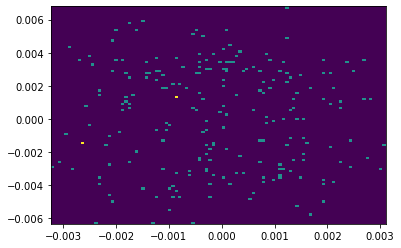

In [70]:
plt.hist2d(particles.particle_x, particles.particle_y, bins=[100,100])
plt.show()

In [71]:
particles.particle_x.shape

(215,)